In [1]:
#from google.colab import files, drive
#drive.mount('/content/drive')

In [2]:
#!pip install -r ./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/requirements.txt

In [3]:

from __future__ import absolute_import

import sys
import os

#sys.path.append('./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/')


In [4]:
#!wandb login

In [5]:
from __future__ import absolute_import

import sys
import os

import shutil

try:
    from dotenv import find_dotenv, load_dotenv
except:
    pass

import argparse

#try:
#    sys.path.append(os.path.join(os.path.dirname(__file__), './drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/'))
#except:
#    sys.path.append(os.path.join(os.getcwd(), './drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/'))
    
try:
    sys.path.append(os.path.join(os.path.dirname(__file__), '../'))
except:
    sys.path.append(os.path.join(os.getcwd(), '../'))
    
import pandas as pd
import numpy as np

import pickle
from collections import Counter
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras.backend as K
#import tensorflow_addons as tfa

try:
    import wandb
    load_dotenv(find_dotenv())
    wandb.login(key=os.environ['WANDB_API_KEY'])
    from wandb.keras import WandbCallback
    _has_wandb = True
except:
    _has_wandb = False

import tokenizers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig, BertTokenizer

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from src import data, models

pd.options.display.max_colwidth = -1

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: WARNING Calling wandb.login() without arguments from jupyter should prompt you for an api key.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/victor/.netrc
wandb: WARNING Unable to patch tensorflow.keras for use with W&B.  You will not be able to log images unless you set the generator argument of the callback.
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [6]:
print (_has_wandb)

True


In [7]:
parser = argparse.ArgumentParser(prog='Trainer',conflict_handler='resolve')

#parser.add_argument('--train_data', type=str, default='./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/data/processed/SarcasmDetection_CodeMixed/data.txt', required=False,
#                    help='train data')
parser.add_argument('--train_data', type=str, default='../data/processed/SarcasmDetection_CodeMixed/data.txt', required=False,
                    help='train data')

parser.add_argument('--val_data', type=str, default=None, required=False,
                    help='validation data')
parser.add_argument('--test_data', type=str, default=None, required=False,
                    help='test data')

parser.add_argument('--transformer_model_pretrained_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer model pretrained path or huggingface model name')
parser.add_argument('--transformer_config_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer config file path or huggingface model name')
parser.add_argument('--transformer_tokenizer_path', type=str, default='bert-base-multilingual-cased', required=False,
                    help='transformer tokenizer file path or huggingface model name')

parser.add_argument('--max_text_len', type=int, default=30, required=False,
                    help='maximum length of text')
parser.add_argument('--max_char_len', type=int, default=150, required=False,
                    help='maximum length of text') #100
parser.add_argument('--max_word_char_len', type=int, default=20, required=False,
                    help='maximum length of text')

parser.add_argument('--emb_dim', type=int, default=128, required=False,
                    help='maximum length of text')
parser.add_argument('--n_layers', type=int, default=2, required=False,
                    help='maximum length of text')
parser.add_argument('--n_units', type=int, default=128, required=False,
                    help='maximum length of text')

parser.add_argument('--epochs', type=int, default=500, required=False,
                    help='number of epochs')
parser.add_argument('--lr', type=float, default=.001, required=False,
                    help='learning rate')
parser.add_argument('--early_stopping_rounds', type=int, default=50, required=False,
                    help='number of epochs for early stopping')
parser.add_argument('--lr_schedule_round', type=int, default=30, required=False,
                    help='number of epochs for learning rate scheduling')

parser.add_argument('--train_batch_size', type=int, default=16, required=False,
                    help='train batch size')
parser.add_argument('--eval_batch_size', type=int, default=8, required=False,
                    help='eval batch size')

#parser.add_argument('--model_save_path', type=str, default='./drive/MyDrive/Hate_detection/Hinglish_Hate_Detection/models/sarcasm_detection/', required=False,
#                    help='seed')

parser.add_argument('--model_save_path', type=str, default='../models/sarcasm_detection/', required=False,
                    help='seed')

parser.add_argument('--wandb_logging', type=bool, default=True, required=False,
                    help='wandb logging needed')

parser.add_argument('--seed', type=int, default=42, required=False,
                    help='seed')


args, _ = parser.parse_known_args()

In [8]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

In [9]:
df = pd.read_csv(args.train_data, sep='\t',header=None,usecols=[0,1])
df.columns = ['text','category']
df = df.dropna()
df = df[df.text != '']

kf = KFold(n_splits=5, shuffle=True, random_state=args.seed)
for train_index, test_index in kf.split(df.text):
    break

train_df = df.iloc[train_index]
kf2 = KFold(n_splits=2, shuffle=True, random_state=args.seed)
for val_index, test_index in kf2.split(df.iloc[test_index].text):
    break

val_df = df.iloc[val_index]
test_df = df.iloc[test_index]

In [10]:
print (train_df.shape, val_df.shape, test_df.shape)

(4200, 2) (525, 2) (525, 2)


In [11]:
train_df.head(5)

,text,category
0,Triple Talaq par Burbak Kuchh nahi bolega,NO
1,Batao ye uss site pr se akki sir ke verdict nikaal laaye jaha he ajay ki ek bi movie hit nai,YES
2,Hindu baheno par julam bardas nahi hoga @TripleTalaq Hindu daram par lago hoga hamari Hindu baheno ki soraksa ke liye,NO
3,Naa bhai.. aisa nhi hai.. mere handle karne se bhi kuchh hona nhi hai.. politics se mera door door tak ka naata nhi hai,NO
4,#RememberingRajiv aaj agar musalman auraten triple talaq ki wajah se itni jaleel ho rahi hai to iss ka sabse bada reason Rajib gandhi hai.,NO


In [12]:
train_df.text = train_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
val_df.text = val_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))
test_df.text = test_df.text.apply(lambda x: data.preprocessing.clean_tweets(x))

/Users/victor/.local/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
train_df = train_df[train_df.text != '']
val_df = val_df[val_df.text != '']
test_df = test_df[test_df.text != '']


In [14]:
train_df.text.apply(lambda x: len(x)).describe()

count    4200.000000
mean     97.934524  
std      33.454326  
min      4.000000   
25%      73.000000  
50%      103.000000 
75%      127.000000 
max      167.000000 
Name: text, dtype: float64

In [15]:
train_df.text.apply(lambda x: len(x.split())).describe()

count    4200.000000
mean     18.300238  
std      6.622981   
min      1.000000   
25%      13.000000  
50%      19.000000  
75%      24.000000  
max      33.000000  
Name: text, dtype: float64

In [16]:
model_save_dir = args.model_save_path

try:
    os.makedirs(model_save_dir)
except OSError:
    pass

In [17]:
train_df.category = train_df.category.apply(lambda x: x.upper())
val_df.category = val_df.category.apply(lambda x: x.upper())
test_df.category = test_df.category.apply(lambda x: x.upper())

In [18]:
train_df.category.value_counts()

NO     3818
YES    382 
Name: category, dtype: int64

In [19]:
model_save_dir

'../models/sarcasm_detection/'

In [20]:
train_df.category, label2idx = data.data_utils.convert_categorical_label_to_int(train_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

val_df.category, _ = data.data_utils.convert_categorical_label_to_int(val_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

test_df.category, _ = data.data_utils.convert_categorical_label_to_int(test_df.category.values, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))

In [21]:
train_df.head(5)

,text,category
0,triple talaq par burbak kuchh nahi bolega,0
1,batao ye uss site pr se akki sir ke verdict nikaal laaye jaha he ajay ki ek bi movie hit nai,1
2,hindu baheno par julam bardas nahi hoga hindu daram par lago hoga hamari hindu baheno ki soraksa ke liye,0
3,naa bhai.. aisa nhi hai.. mere handle karne se bhi kuchh hona nhi hai.. politics se mera door door tak ka naata nhi hai,0
4,aaj agar musalman auraten triple talaq ki wajah se itni jaleel ho rahi hai to iss ka sabse bada reason rajib gandhi hai.,0


In [22]:
print (label2idx)

{'NO': 0, 'YES': 1}


In [23]:
idx2label = {i:w for (w,i) in label2idx.items()}

### Learn tokenizer

In [24]:
#data.custom_tokenizers.custom_wp_tokenizer(train_df.text.values, args.model_save_path, args.model_save_path)
tokenizer = BertTokenizer.from_pretrained(args.model_save_path)
#tokenizer = AutoTokenizer.from_pretrained(args.transformer_tokenizer_path)

In [25]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=50000, split=' ',oov_token=1)
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, split='',oov_token=1)

word_tokenizer.fit_on_texts(train_df.text.values)
char_tokenizer.fit_on_texts(train_df.text.values)

In [26]:
transformer_train_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(train_df, 'text', tokenizer, args.max_char_len)

word_train_inputs = word_tokenizer.texts_to_sequences(train_df.text.values)
word_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_train_inputs, maxlen=args.max_text_len)

subword_train_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(train_df.text.values)])

char_train_inputs = char_tokenizer.texts_to_sequences(train_df.text.values)
char_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_train_inputs, maxlen=args.max_char_len)

train_outputs = data.data_utils.compute_output_arrays(train_df, 'category')

transformer_val_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(val_df, 'text', tokenizer, args.max_char_len)

word_val_inputs = word_tokenizer.texts_to_sequences(val_df.text.values)
word_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_val_inputs, maxlen=args.max_text_len)

subword_val_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(val_df.text.values)])

char_val_inputs = char_tokenizer.texts_to_sequences(val_df.text.values)
char_val_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_val_inputs, maxlen=args.max_char_len)

val_outputs = data.data_utils.compute_output_arrays(val_df, 'category')

transformer_test_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(test_df, 'text', tokenizer, args.max_char_len)

word_test_inputs = word_tokenizer.texts_to_sequences(test_df.text.values)
word_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_test_inputs, maxlen=args.max_text_len)

subword_test_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                        for text in tqdm(test_df.text.values)])

char_test_inputs = char_tokenizer.texts_to_sequences(test_df.text.values)
char_test_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_test_inputs, maxlen=args.max_char_len)

test_outputs = data.data_utils.compute_output_arrays(test_df, 'category')

train_outputs = tf.keras.utils.to_categorical(train_outputs, \
                                                    num_classes=train_df.category.nunique())
val_outputs = tf.keras.utils.to_categorical(val_outputs, \
                                                    num_classes=train_df.category.nunique())
test_outputs = tf.keras.utils.to_categorical(test_outputs, \
                                                    num_classes=train_df.category.nunique())

tfidf1 = TfidfVectorizer(stop_words='english',ngram_range=(1,3), max_df=.6,min_df=2)
tfidf2 = TfidfVectorizer(analyzer='char_wb',ngram_range=(1,3), max_df=.6,min_df=2)

tfidf1.fit(train_df.text)
tfidf2.fit(train_df.text)

train_tfidf = np.hstack([tfidf1.transform(train_df.text).toarray(),tfidf2.transform(train_df.text).toarray()])
val_tfidf = np.hstack([tfidf1.transform(val_df.text).toarray(),tfidf2.transform(val_df.text).toarray()])
test_tfidf = np.hstack([tfidf1.transform(test_df.text).toarray(),tfidf2.transform(test_df.text).toarray()])


print (transformer_train_inputs.shape, subword_train_inputs.shape, word_train_inputs.shape, char_train_inputs.shape, \
       train_tfidf.shape, train_outputs.shape)
print (transformer_val_inputs.shape, subword_val_inputs.shape, word_val_inputs.shape, char_val_inputs.shape, \
       val_tfidf.shape, val_outputs.shape)
print (transformer_test_inputs.shape, subword_test_inputs.shape, word_test_inputs.shape, char_test_inputs.shape, \
       test_tfidf.shape, test_outputs.shape)


100%|██████████| 525/525 [00:00<00:00, 1756.31it/s]


(4200, 150) (4200, 30, 20) (4200, 30) (4200, 150) (4200, 20091) (4200, 2)
(525, 150) (525, 30, 20) (525, 30) (525, 150) (525, 20091) (525, 2)
(525, 150) (525, 30, 20) (525, 30) (525, 150) (525, 20091) (525, 2)


### Modeling

In [27]:
n_words = len(word_tokenizer.word_index)+1
n_chars = len(char_tokenizer.word_index)+1
n_subwords = tokenizer.vocab_size
print (n_words, n_chars, n_subwords)
tfidf_shape = train_tfidf.shape[1]
n_out = train_df.category.nunique()

12489 56 5517


In [28]:
from src.models.models import *

In [29]:
_has_wandb = False

In [30]:
loss = 'ce'
model_name = 'Transformer'
model1 = Transformer(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model1.load_weights(model_save_path)

model2 = Transformer(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model2.load_weights(model_save_path)

In [31]:
loss = 'ce'
model_name = 'HAN'
model3 = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model3.load_weights(model_save_path)

model4 = HAN(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model4.load_weights(model_save_path)

In [32]:
loss = 'ce'
model_name = 'WLSTM'
model5 = WLSTM(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))

model5.load_weights(model_save_path)

model6 = WLSTM(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=n_subwords, vectorizer_shape=None, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=150,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_without_features.h5'.format(model_name, loss))

model6.load_weights(model_save_path)

In [33]:
test_df.category = [idx2label[i] for i in test_df.category]

test_pred = model1.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['Transformer_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model3.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['HAN_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model5.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs, test_tfidf])

test_df['WLSTM_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]


In [34]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          model_name,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest',cmap=cmap) #, 
    plt.title(title)
    #plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    #print (thresh)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_ = np.around(cm_, decimals=2)
        #print (cm)
    else:
      cm_ = cm

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if cm_[i, j] > 0:
        if normalize:
            plt.text(j, i, "{:0.2f}".format(round(cm_[i, j],2)),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm_[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    SMALL_SIZE = 25
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 25

    #plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "15"

    
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.savefig('../plots/sarcasm_{}.pdf'.format(model_name),dpi=200)
    plt.show()
    
def get_conditional_weights(text, model, class_idx):
    all_texts = [" ".join(text.split()[:i]) for i in range(len(text.split())+1)][1:]
    #all_texts = [text]*(len(text.split())+1)
    word_train_inputs = word_tokenizer.texts_to_sequences(all_texts)
    word_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(word_train_inputs, maxlen=args.max_text_len)

    subword_train_inputs = np.asarray([data.data_utils.subword_tokenization(text, char_tokenizer, args.max_text_len, args.max_word_char_len) \
                            for text in all_texts])

    char_train_inputs = char_tokenizer.texts_to_sequences(all_texts)
    char_train_inputs = tf.keras.preprocessing.sequence.pad_sequences(char_train_inputs, maxlen=args.max_char_len)
    
    for i in range(len(text.split())):
        #subword_train_inputs_ = subword_train_inputs.copy()
        subword_train_inputs[i,i,:] = np.array([0]*subword_train_inputs.shape[-1])
        
    #print (subword_train_inputs[-1])
    probs = model.predict([word_train_inputs,char_train_inputs,subword_train_inputs,\
                                      char_train_inputs])
    
    #print (probs)
    #print (all_texts)
    
    probs_ = probs[-1] - probs
    #class_idx = probs.argmax(-1)[-1]
    
    return probs_[:,class_idx]

import html
from IPython.core.display import display, HTML

def html_escape(text):
    return html.escape(text)

def gradient_plots(text,weights,max_alpha=.3):
    highlighted_text = []

    for i, word in enumerate(text.split()):
        
        if i < args.max_text_len:
            weight = weights[i]

            if weight is not None:
                highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(weight / max_alpha) + ');">' + html_escape(word) + '</span>')
            else:
                highlighted_text.append(word)
            
    highlighted_text = ' '.join(highlighted_text)
    
    return highlighted_text

def plot_attention(attention, sentence,plot_size=12, filename='image.pdf'):
    fig = plt.figure(figsize=(plot_size,plot_size))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Blues')

    fontdict = {'fontsize': 30}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=45)
    ax.set_yticklabels([''] + sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    SMALL_SIZE = 30
    MEDIUM_SIZE = 30
    BIGGER_SIZE = 30
    
    #plt.show()
    plt.rcParams["font.family"] = 'sans-serif' #"Times New Roman"
    plt.rcParams["font.size"] = "25"

    
    #plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.xlabel("")
    plt.ylabel("")
    plt.title("")
    
    plt.savefig(filename, dpi=200)

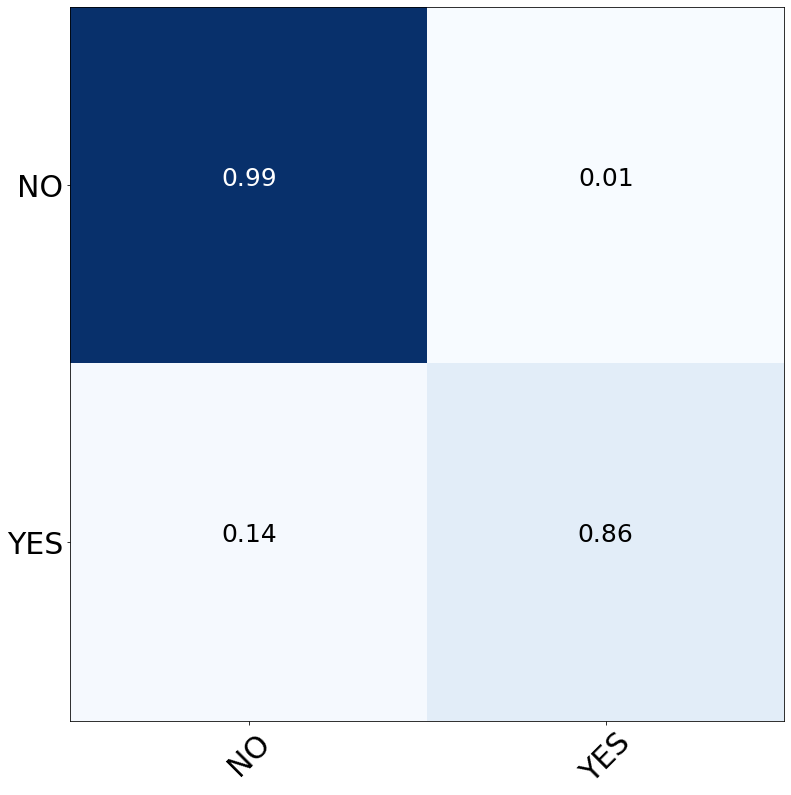

In [53]:
cm = pd.crosstab(test_df.category, test_df.Transformer_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = True,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='Transformer')

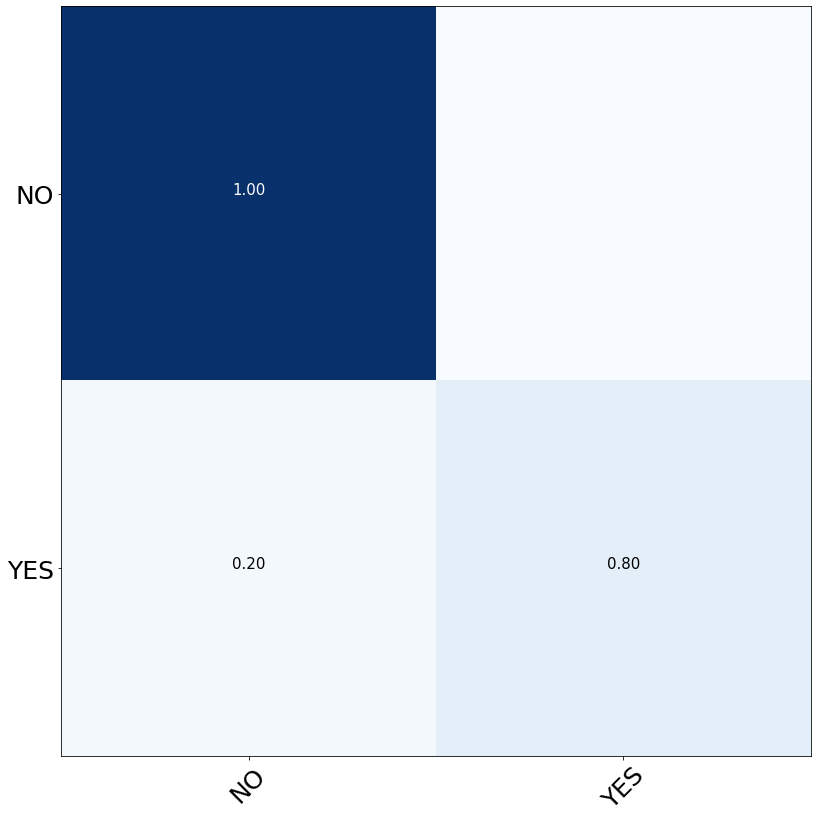

In [36]:
cm = pd.crosstab(test_df.category, test_df.HAN_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = True,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='HAN')

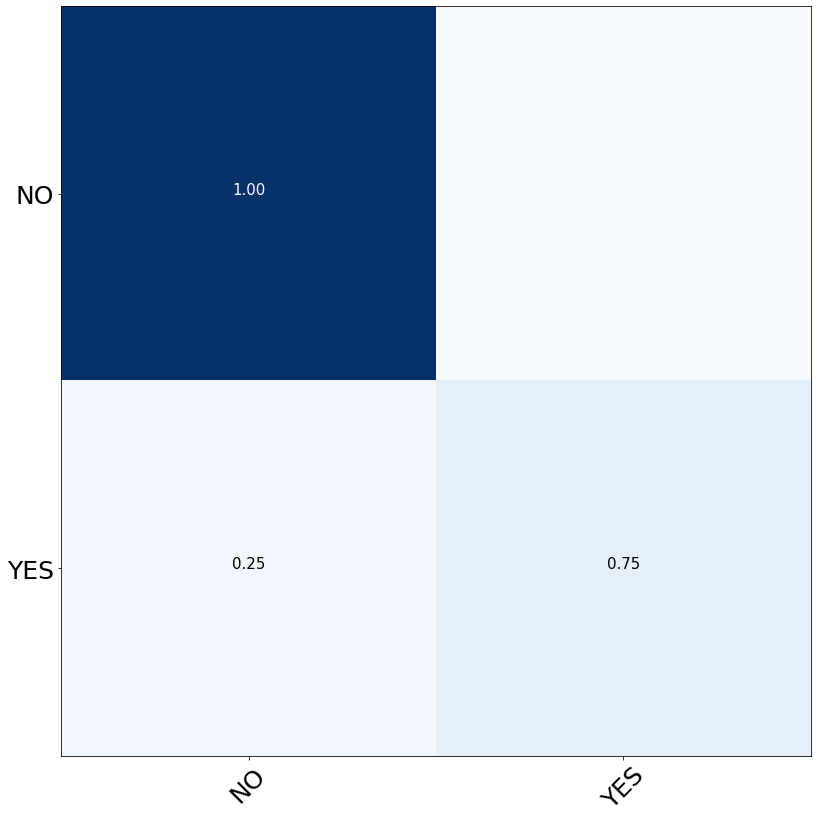

In [37]:
cm = pd.crosstab(test_df.category, test_df.WLSTM_pred)
cm = cm[cm.index]
cm
plot_confusion_matrix(cm           = cm.values, 
                      normalize    = True,
                      target_names = cm.index.to_list(),
                      title        = "Confusion Matrix",
                     model_name='WLSTM')

In [38]:
test_df = test_df.reset_index(drop=True)

test_pred = model2.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['Transformer_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model4.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['HAN_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

test_pred = model6.predict([word_test_inputs, char_test_inputs, subword_test_inputs, transformer_test_inputs])

test_df['WLSTM_pred'] = [idx2label[i] for i in test_pred.argmax(-1)]

In [39]:
test_df[test_df.category != test_df.Transformer_pred].head(20)

,text,category,Transformer_pred,HAN_pred,WLSTM_pred
32,"arey aap ki company ki advertisement kum ho gai ?aisa mat kariyo,aap thode aur lutt lo aam janta ko lekin top par raho",YES,NO,NO,NO
36,kam se kam jai shree ram keh k jaan to bach jaati hai..... kahi allah hu akhbar keh k jaane le li jaati hai.....,YES,NO,YES,NO
58,ab kaun aajkal aise twitter mein bhi darshan dete hain?! ki tarah! hum dhanya hue!,YES,NO,YES,NO
76,yaar ek ehsaan mujh par karna ki mujhpar koi ehsaan mat karna,NO,YES,YES,NO
127,ye pakistani sainik ka khat hoga. bhatiye hota to patra likhta tatsam hindi ya sanskrit mein,YES,NO,NO,NO
180,"so, how dare he ki wo ek neta k rishtedaar ka chlaan kaate aukaat kya hai iski ek mamuli sa police wala",YES,NO,YES,NO
220,"jaani jo log sonay ki chain galay may daltay hain ,woh shirt ke uppar wala button nahi daltay !",NO,YES,YES,YES
280,u.p me log chutiya aur electricity bahot jada kaatte,YES,NO,NO,NO
284,'kamar patli jitni utna hi zyada mazaa hai'' this while salman grabbing zareen khan's waist!,YES,NO,YES,YES
322,"mera bharat mahan ! beti bachao, beti padhao, indeed ! pic.twitter.com/ezkoaipv",YES,NO,NO,NO


In [40]:
label2idx

{'NO': 0, 'YES': 1}

In [41]:
text = test_df.text.iloc[58]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model2, 1))

display(HTML(highlighted_text))


In [42]:
text = test_df.text.iloc[58]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model4, 1))

display(HTML(highlighted_text))


In [43]:
text = test_df.text.iloc[58]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model6, 1))

display(HTML(highlighted_text))


In [44]:
text = test_df.text.iloc[322]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model2, 1))

display(HTML(highlighted_text))


In [45]:
text = test_df.text.iloc[322]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model4, 1))

display(HTML(highlighted_text))


In [46]:
text = test_df.text.iloc[322]

highlighted_text = gradient_plots(text,get_conditional_weights(text, model6, 1))

display(HTML(highlighted_text))


In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def get_word_attention(text, model, tokenizer,model_name):
    df = pd.DataFrame()
    df['text'] = [text]
    transformer_val_inputs, _, _ = data.data_utils.compute_transformer_input_arrays(df, 'text', tokenizer, args.max_char_len)
    
    print (transformer_val_inputs.shape)
    
    pos = model.layers[1](transformer_val_inputs)
    embs = model.layers[2](pos)
    
    attn = model.layers[3].att
    
    batch_size = tf.shape(embs)[0]
    query = attn.query_dense(embs)  # (batch_size, seq_len, embed_dim)
    key = attn.key_dense(embs)  # (batch_size, seq_len, embed_dim)
    value = attn.value_dense(embs)  # (batch_size, seq_len, embed_dim)
    query = attn.separate_heads(
        query, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    key = attn.separate_heads(
        key, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    value = attn.separate_heads(
        value, batch_size
    )  # (batch_size, num_heads, seq_len, projection_dim)
    attention, weights = attn.attention(query, key, value)
    weights = weights.numpy().mean(1)[0]

    sentence = tokenizer.tokenize(text) #text.split()
    try:
        plot_attention(weights[:len(sentence),:len(sentence)],sentence,filename='../plots/attention_sarcasm_{}.pdf'.format(model_name))
    except:
        plot_attention(weights,sentence,filename='../plots/attention_sarcasm_{}.pdf'.format(model_name))

In [48]:
test_df.tail(20)

,text,category,Transformer_pred,HAN_pred,WLSTM_pred
505,bangladesh win! pic.twitter.com/vvezqjkke,NO,NO,NO,NO
506,yeh triple talaq kya hota hai ?,NO,NO,NO,NO
507,main khyal hun kisi aur ka mujhey sochta koi aur hey,YES,YES,YES,YES
508,"tripletalaq pe mullas moulavis,muslim auraton pezulm karte rehna chahte hein.owaisi khdeda hawa naqlee neta halal ke chakkar me hai",NO,NO,NO,NO
509,"oye jyada politics naa kar, usne sirf ek din ke liye ban lagaya hai, taaki communal harmony bani rahe",NO,NO,NO,NO
510,sir sunanda ko hi de dete... maaraa kyun? aisa mai nahi laug kehte hai...,NO,NO,NO,NO
511,dear yeh baat sach h log ka najais istemal kr rahe the unki jahalat k vajeh se islam ko badnaam ho raha h...,NO,NO,NO,NO
512,"politics ke liye kuch log kuch bhi karne ke liye taiyar rahte hai. lasho pe bhi siasat. but then again, aap is wannabe congress with no base",NO,NO,NO,NO
513,"aree vaiya, rohit sharma aur shikhar dhawan alag alag admi hai aur cricket khelte hai.. sab ek kardiya apne",NO,NO,NO,NO
514,humari indian politics sabse ghatyaa ho chuki hai vote ke kisi v apradhi mamla mai juree person ko sath detaie ha aur har sambhav sahoyg ...,NO,NO,NO,NO


100%|██████████| 1/1 [00:00<00:00, 1451.82it/s]
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator


(1, 150)


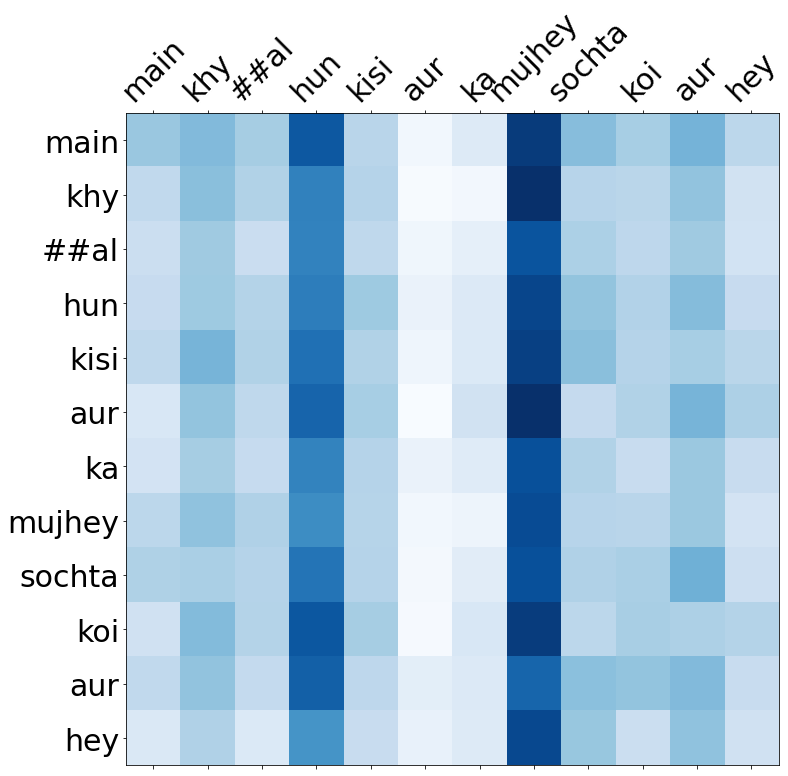

In [49]:
get_word_attention(test_df.text.iloc[507], model1, tokenizer, 'Transformer')

In [50]:
def get_word_attention_bert(text, bert_model, bert_tokenizer,filename='../plots/attention_sarcasm_BERT.pdf'):
    
    input = np.array(bert_tokenizer.encode(text))[np.newaxis,:]

    out = bert_model(input)
    
    weights = out[-1][-1].numpy().mean(1)[0]
    
    sentence = tokenizer.tokenize(text) #text.split()
    
    try:
        plot_attention(weights[:len(sentence),:len(sentence)],sentence,filename=filename)
    except:
        plot_attention(weights,sentence,filename=filename)

In [51]:
model_name = 'BERT'
loss = 'ce'
bert_tokenizer = AutoTokenizer.from_pretrained(args.transformer_tokenizer_path)
bert_model = BERT(word_vocab_size=n_words,char_vocab_size=n_chars,wpe_vocab_size=bert_tokenizer.vocab_size, vectorizer_shape=tfidf_shape, n_out=n_out,\
                               transformer_model_pretrained_path=args.transformer_model_pretrained_path,max_word_char_len=args.max_word_char_len,\
                                             max_text_len=args.max_text_len, max_char_len=100,\
                                             n_layers=args.n_layers, n_units=args.n_units, emb_dim=args.emb_dim)
model_save_path = os.path.join(args.model_save_path, '{}_{}_with_features.h5'.format(model_name, loss))
bert_model.load_weights(model_save_path)

base_model = bert_model.layers[1]
base_model.save_pretrained('./')

config = AutoConfig.from_pretrained(args.transformer_config_path, output_attentions=True)

base_model = TFAutoModel.from_pretrained('./', config=config)


/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: UserWarning: FixedFormatter should only be used together with FixedLocator


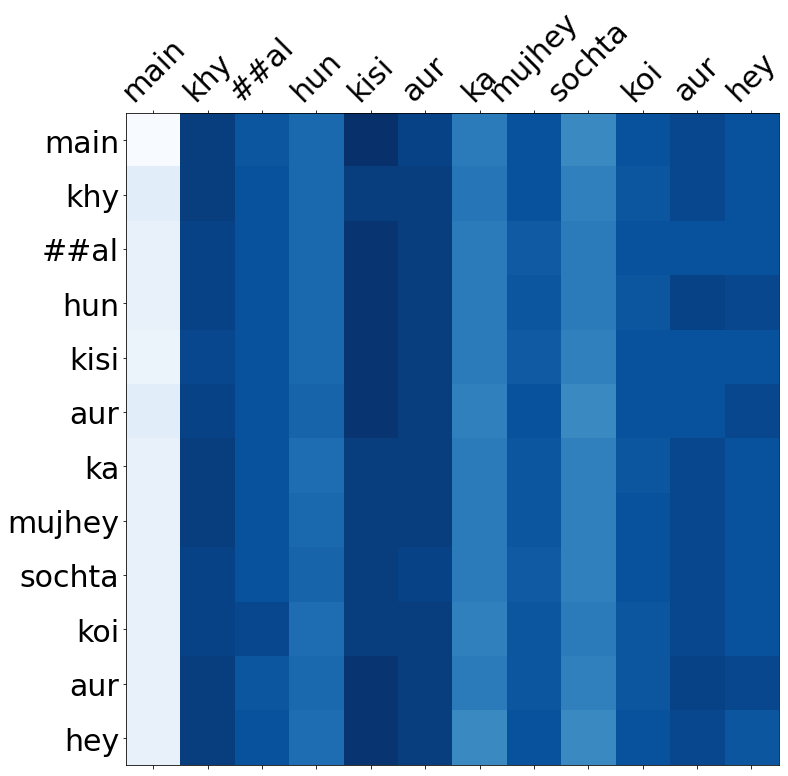

In [52]:
get_word_attention_bert(test_df.text.iloc[507], base_model, bert_tokenizer)